# Programming Solutions: Discriminative vs Generative Models
**Course:** Artificial Intelligence (2025) · Shiraz University

## Task 1 – Data Exploration & Gaussian Fitting
**Bullet‐by‐bullet requirements**
1. Handle missing or invalid values via deletion or imputation.
2. Plot distributions (histogram or KDE) of all features per class.
3. Select two informative features (e.g. `chol` and `thalach`).
4. Fit **2‑D Gaussian** distributions (one per class) and plot contour maps.
5. Evaluate Gaussian assumption via plots and (optional) normality tests.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#########################
# 1) Load & clean data  #
#########################
PATH = 'data/heart_disease_uci.csv'
df = pd.read_csv(PATH)

print(f'Dataset shape: {df.shape}')

Dataset shape: (920, 16)


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
# extract the target column
df["num"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.num.head()

0    0
1    1
2    1
3    0
4    0
Name: num, dtype: int64

In [13]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

### Handling Missing Data: Rationale

We applied different strategies for handling missing data based on the proportion of missing values and the nature of each column:

#### ✅ Imputed Columns:
- **`trestbps`**, **`chol`**, **`thalch`**, **`oldpeak`**:
  These are numerical columns with relatively low missingness (<10%).
  ➤ Imputed using **median** to avoid skewing distributions.

- **`fbs`**, **`restecg`**, **`exang`**:
  These are categorical (or binary-like) columns with manageable missingness.
  ➤ Imputed using **mode** (most frequent value).

#### ❌ Dropped Columns:
- **`slope`** (~34% missing), **`ca`** (~66% missing), **`thal`** (~53% missing):
  These columns have a **high percentage of missing values**, making imputation unreliable and potentially biased.
  ➤ Chosen to **drop** these columns to maintain data integrity.

This approach balances preserving valuable data while avoiding distortion due to excessive imputation.


In [14]:
# Handle missing data: impute or delete based on proportion and type

# Impute numeric columns with median
df['trestbps'].fillna(df['trestbps'].median(), inplace=True)  # ~6% missing
df['chol'].fillna(df['chol'].median(), inplace=True)          # ~3% missing
df['thalch'].fillna(df['thalch'].median(), inplace=True)      # ~6% missing
df['oldpeak'].fillna(df['oldpeak'].median(), inplace=True)    # ~7% missing

# Impute categorical columns with mode
df['fbs'].fillna(df['fbs'].mode()[0], inplace=True)            # ~10% missing
df['restecg'].fillna(df['restecg'].mode()[0], inplace=True)    # <1% missing
df['exang'].fillna(df['exang'].mode()[0], inplace=True)        # ~6% missing

# Drop columns with high missingness
df.drop(columns=['slope', 'ca', 'thal'], inplace=True)         # >30% missing

# Final check
print("Remaining missing values:\n", df.isnull().sum())


Remaining missing values:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64


### Feature Distributions by Target Class

We visualized the distribution of each feature in the dataset, split by the `num` target class:

- **Numerical features** (e.g., `age`, `chol`, `thalch`) were plotted using **KDE (Kernel Density Estimate)** to compare the shapes of their distributions between classes.
- **Categorical features** (e.g., `sex`, `cp`, `restecg`) were plotted using **count plots** to show the frequency of each category per class.

These plots help in understanding which features might be informative for distinguishing between patients with and without heart disease.


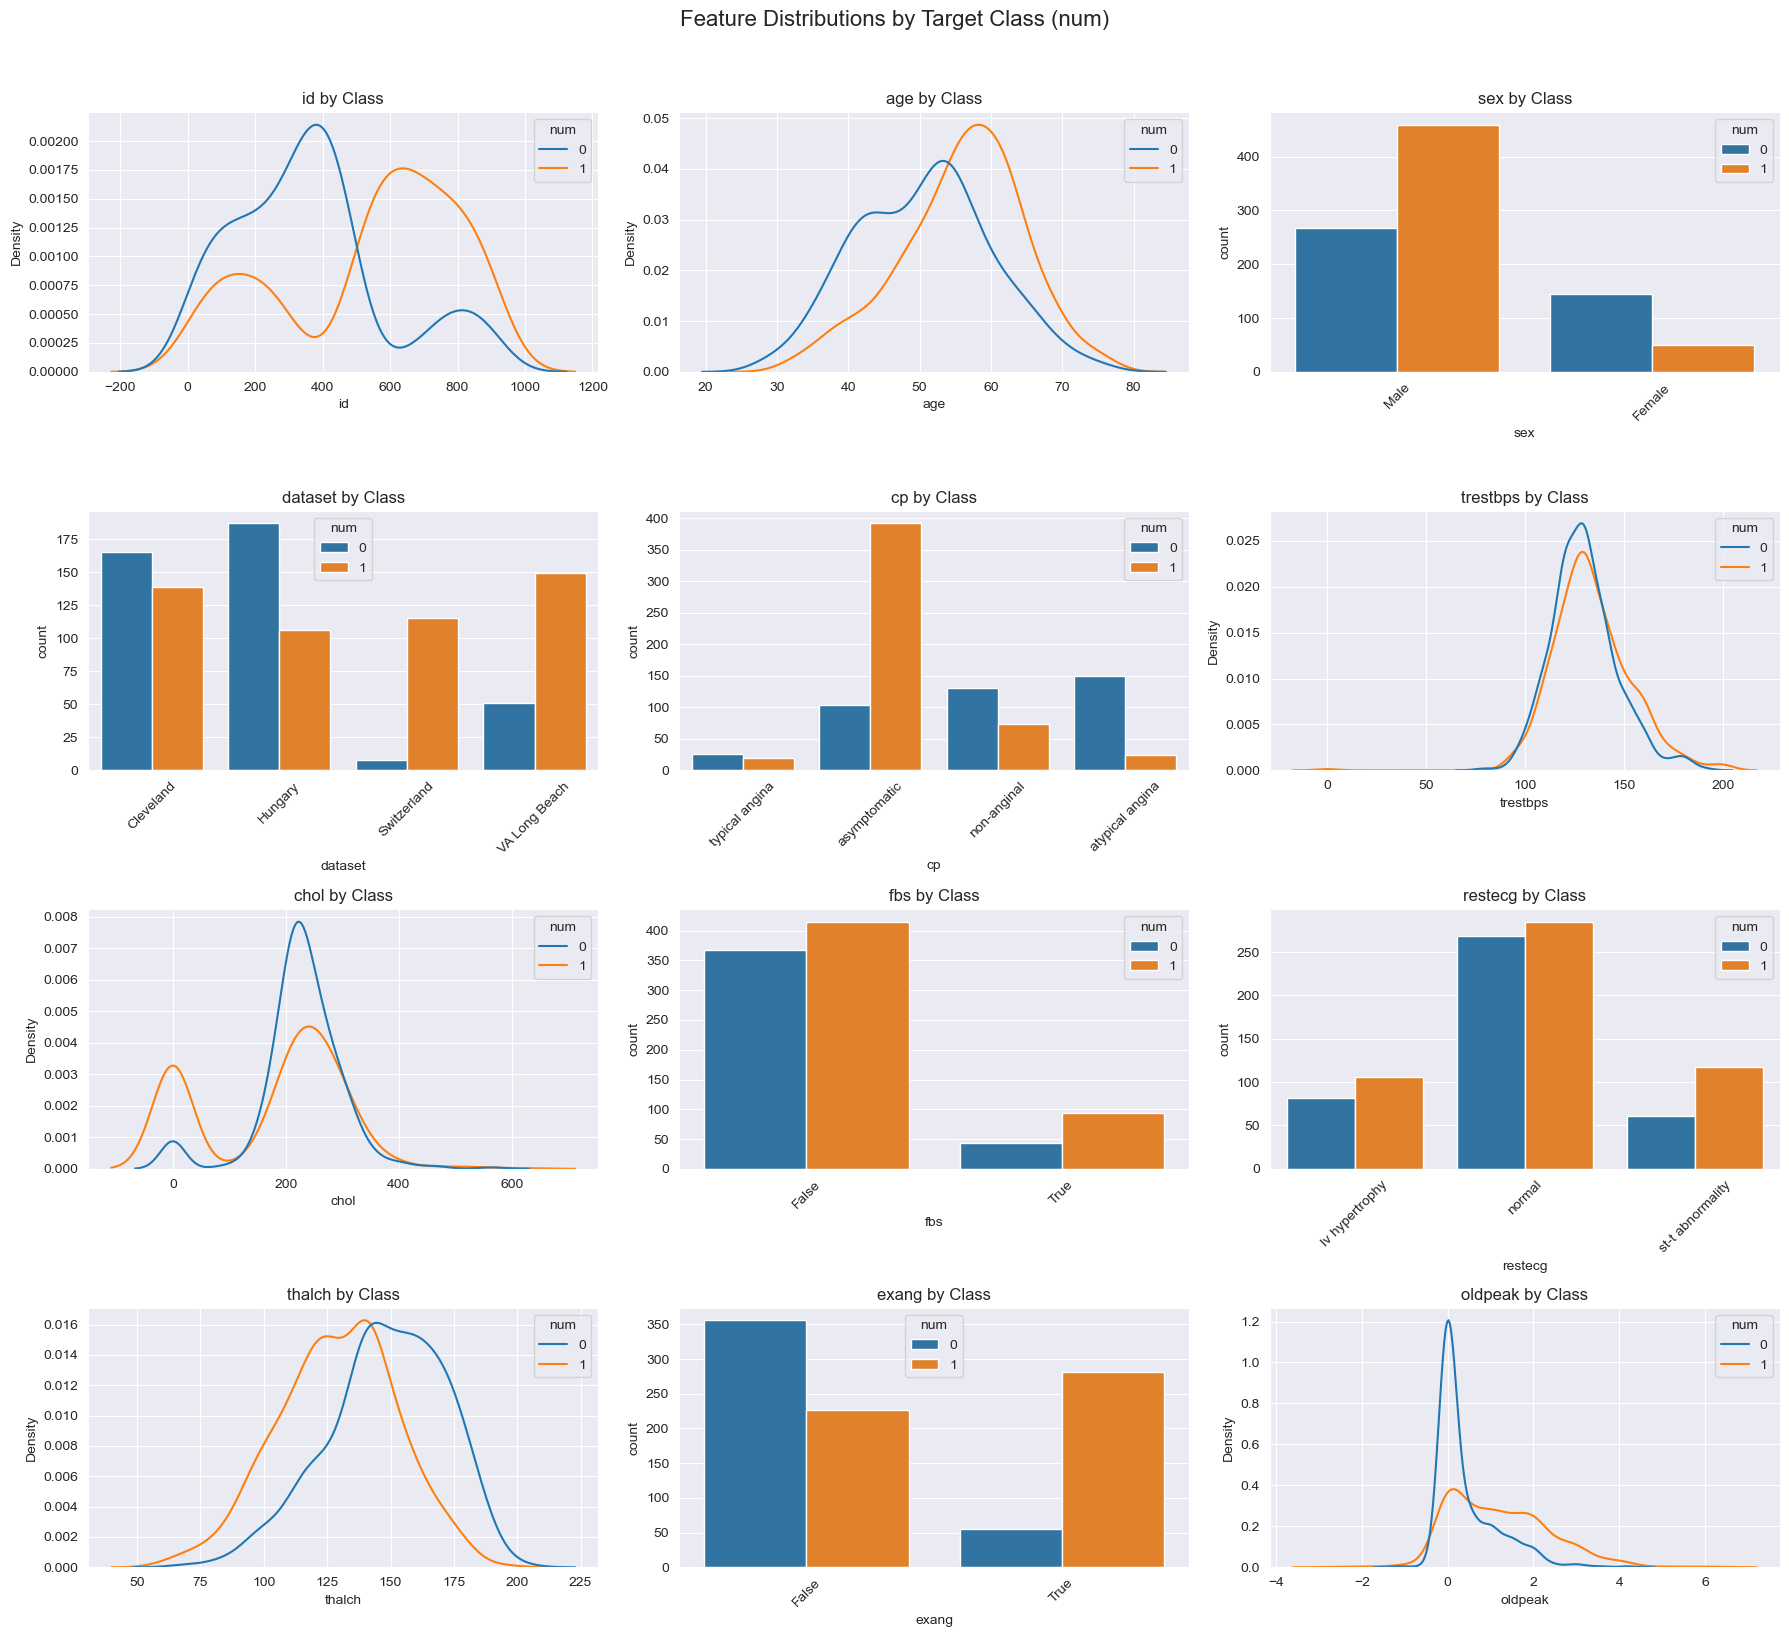

In [16]:
# Identify feature columns and target
feature_cols = [col for col in df.columns if col != 'num']
target_col = 'num'

# Define grid dimensions
cols = 3
rows = (len(feature_cols) + cols - 1) // cols  # equivalent to math.ceil

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(feature_cols):
    ax = axes[i]

    if df[col].dtype in ['float64', 'int64']:
        sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, ax=ax)
    else:
        sns.countplot(data=df, x=col, hue=target_col, ax=ax)
        ax.tick_params(axis='x', rotation=45)

    ax.set_title(f'{col} by Class')

# Remove extra subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Feature Distributions by Target Class (num)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Selecting Informative Features

We selected two informative features for further analysis:

- **`chol`**: Serum cholesterol level, a key cardiovascular risk indicator.
- **`thalch`**: Maximum heart rate achieved during exercise, often used to assess cardiac function.

These features are relevant to heart disease and show variation across target classes (`num`).


In [17]:
# Select two informative features: 'chol' (cholesterol) and 'thalch' (maximum heart rate)
selected_features = df[['chol', 'thalch', 'num']]

# Display the first few rows of the selected data
selected_features.head()


,chol,thalch,num
0,233.0,150.0,0
1,286.0,108.0,1
2,229.0,129.0,1
3,250.0,187.0,0
4,204.0,172.0,0


### 2D Gaussian Contours on Selected Features

We selected two informative features:

- **`chol`**: Serum cholesterol level
- **`thalch`**: Maximum heart rate achieved during exercise

Using only `pandas`, `numpy`, `matplotlib`, and `seaborn`:

- We computed the **mean** and **covariance matrix** of these two features for each class in `num`.
- We manually evaluated the **multivariate Gaussian PDF** to draw class-specific **contour maps** over the feature space.
- These contours represent high-probability regions for each class and provide visual insight into how well-separated the classes are based on these two variables.

This method provides a visual approximation of class distributions without relying on external libraries like `scipy`.


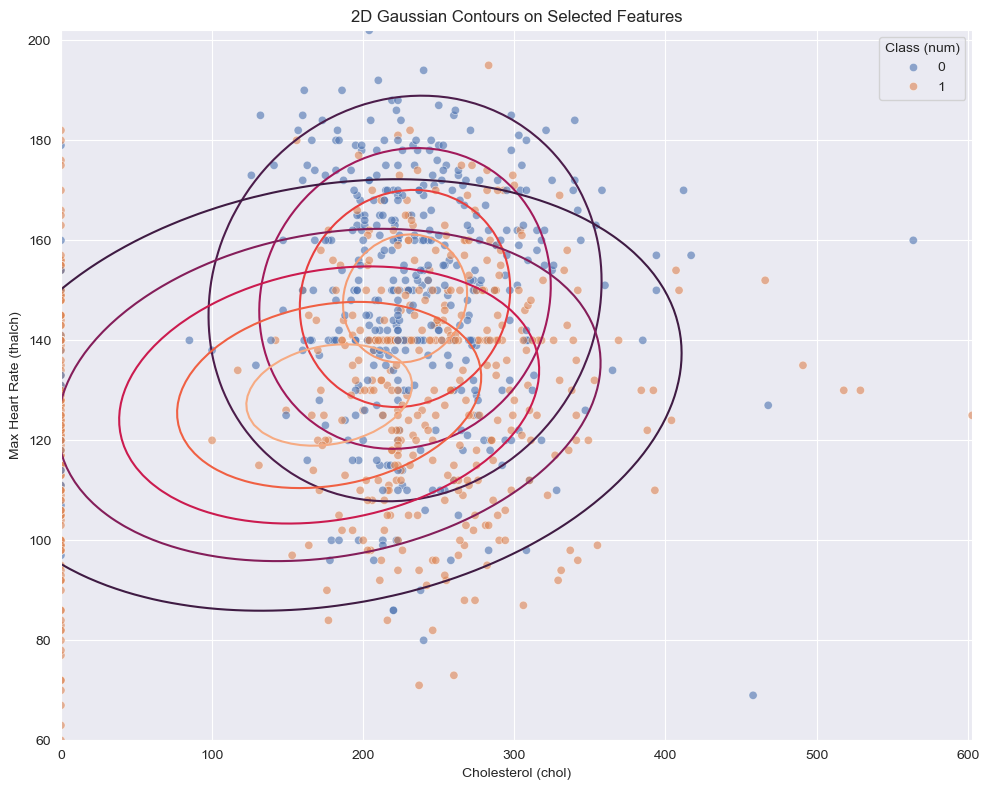

In [18]:
# Fit 2D Gaussians manually per class
def gaussian_pdf(x, mean, cov):
    size = len(mean)
    det = np.linalg.det(cov)
    norm_const = 1.0 / (np.power((2 * np.pi), size / 2) * np.sqrt(det))
    x_mu = x - mean
    inv = np.linalg.inv(cov)
    result = np.einsum('...k,kl,...l->...', x_mu, inv, x_mu)
    return norm_const * np.exp(-0.5 * result)

# Compute Gaussian parameters for each class
gaussians = {}
for cls in selected_features['num'].unique():
    cls_data = selected_features[selected_features['num'] == cls][['chol', 'thalch']].values
    mean = np.mean(cls_data, axis=0)
    cov = np.cov(cls_data, rowvar=False)
    gaussians[cls] = (mean, cov)

# Generate mesh grid for contour plotting
x = np.linspace(selected_features['chol'].min(), selected_features['chol'].max(), 100)
y = np.linspace(selected_features['thalch'].min(), selected_features['thalch'].max(), 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Plot scatter and contours
plt.figure(figsize=(10, 8))
sns.scatterplot(data=selected_features, x='chol', y='thalch', hue='num', palette='deep', alpha=0.6)

for cls, (mean, cov) in gaussians.items():
    Z = gaussian_pdf(pos, mean, cov)
    plt.contour(X, Y, Z, levels=5)

plt.title('2D Gaussian Contours on Selected Features')
plt.xlabel('Cholesterol (chol)')
plt.ylabel('Max Heart Rate (thalch)')
plt.legend(title='Class (num)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Evaluating Gaussian Assumption (Visual-Only, No SciPy)

To assess whether the features `chol` and `thalch` follow a normal (Gaussian) distribution, we used visual diagnostics:

#### Visual Tools:
- **Histogram + KDE**: Shows the overall distribution and smooth density curve.
- **Q-Q Plot (Manual)**: We approximated a quantile-quantile plot using NumPy by comparing data quantiles to those from a normal distribution.
- **Boxplot**: Highlights symmetry, spread, and presence of outliers.

While this analysis avoids statistical tests (due to the SciPy restriction), visual inspection gives a strong first impression of how well each feature adheres to the Gaussian assumption.

These checks inform the appropriateness of modeling with Gaussian-based methods like 2D multivariate normal distributions.


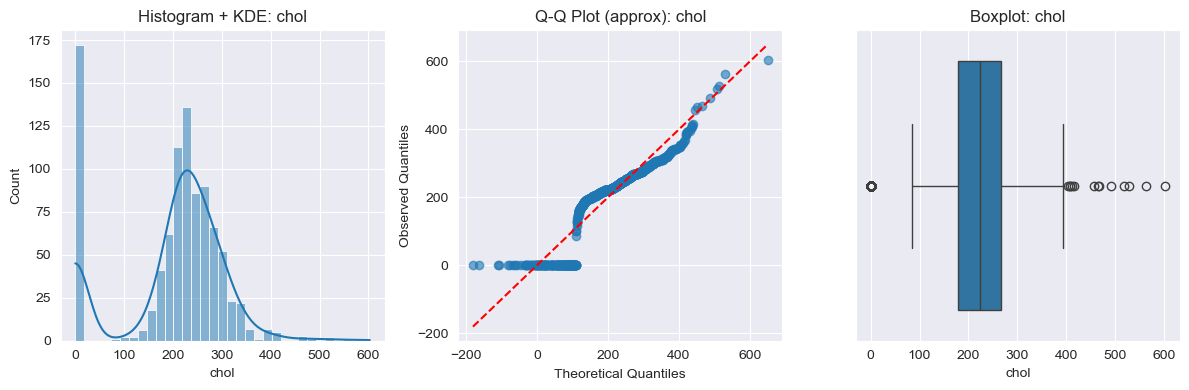

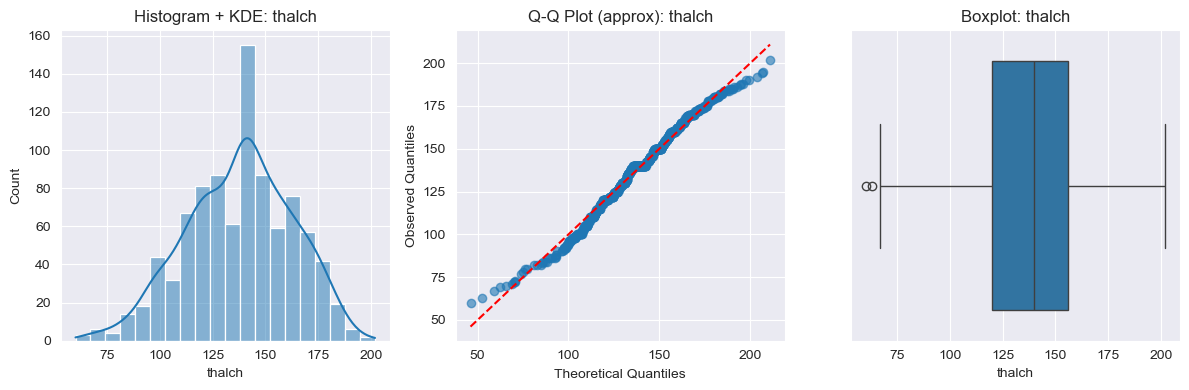

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select features and clean
selected = df[['chol', 'thalch']]

# Visual evaluation of Gaussian assumption
for col in selected.columns:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Histogram with KDE
    sns.histplot(selected[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram + KDE: {col}')

    # Q-Q plot using NumPy quantiles
    sorted_data = np.sort(selected[col].values)
    norm_quantiles = np.sort(np.random.normal(loc=np.mean(sorted_data), scale=np.std(sorted_data), size=len(sorted_data)))
    axes[1].scatter(norm_quantiles, sorted_data, alpha=0.6)
    axes[1].plot([norm_quantiles[0], norm_quantiles[-1]], [norm_quantiles[0], norm_quantiles[-1]], 'r--')
    axes[1].set_title(f'Q-Q Plot (approx): {col}')
    axes[1].set_xlabel('Theoretical Quantiles')
    axes[1].set_ylabel('Observed Quantiles')

    # Boxplot
    sns.boxplot(x=selected[col], ax=axes[2])
    axes[2].set_title(f'Boxplot: {col}')

    plt.tight_layout()
    plt.show()
